# Analysis for XMM EPIC-PN Large Window Mode Energy Scale Analysis

## Long-term CTI turned off, Cu K$\alpha$ analysis

**Note:** This workflow starts from an already processed event list to spectra and already fitted Cu K$\alpha$ 8.04 keV line.

All scripts are in `~/Dropbox/Work/XMM/xmmpy/scripts` folder.

The preliminary processing is done with the following steps:
1. Run `pn_lw_step01.py` to download the ODF and run `cifbuild` and `odfingest`
2. Run `pnlw_nofilt_proc.py <OBS_ID> "noctix" -c` to process up to spectra. The products will be saved in a subfolder `noctix`.
3. Run script `cu_line_analysis_noctix.py` to fit the Cu K$\alpha$ line for the no CTI processing and store the results in `fit_results_cuka_noctix.csv`. 

4. After implementing the new long-term CTI curves in test CCF, run <br/>
`pnlw_nofilt_proc_grid_v1.py $obsid "cti54_test1" --wdir /home/ivaltchanov/IVAN/Cu-line -c -t`

In the **new** versions, `noctix` or `cti54_testN`, no mask is applied, the full CCDs are selected at the `evselect` stage, the output spectra and event lists are per CCD. For CCDs 1, 4, 7 and 10 the filtering is for `RAWY in [100:120]`. 

The output products from step 2 are event lists and spectra with the following names, in subfolders as specified in the call:
* Event lists: `pn_XX_patYY_events.fits`
* Spectra: `pn_XX_patYY_spec5.fits`

where `XX` is the CCDNR from 01 to 12, `patYY` is the pattern, can be `pat00` for `PATTERN == 0` or `pat14` for `PATTERN in [1:4]`.

Once the per-CCD spectra are prepared then we proceed with fitting the Cu K$\alpha$ line:


5. Run script `cu_line_analysis_ctix.py` to fit the Cu K$\alpha$ line and store the results in `fit_results_cuka_cti54_testN.csv`. 

_Ivan Valtchanov_, 09 Aug 2019

Updates:
* 18 Oct 2019
* 03 Feb 2020: adding new observations after the last one used in the `EPN_CTI_0049/0050`. 
* 06 Feb 2020: generating a new CCF file based on the new observations. Per quadrant. Two test CCF files **EPN_CTI_0054.CCF** be generated:
  1. This notebook, will produce `EPN_CTI_0054.CCF` by freezing the `TCOEFF` for t <= 15 and only deriving a new piece-wise curve for t > 15
* 14 Feb 2020: as in 06 Feb 2020 but will fix the `TCOEFF` at t=0 to one and the same value for all CCDs. output CCF will be called `EPN_CTI_0054.CCF_testa0


In [1]:
#
# necessary import packages
#
import os
import numpy as np
import glob
#import altair as alt
import pandas as pd

from astropy.table import Table, Column, vstack
from astropy.io import fits
#from scipy.interpolate import UnivariateSpline
home = os.path.expanduser('~')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
def read_cti_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN CTI calfile and get the dat ain a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    # energy_index = 2 is for Fe Ka at 6.4 keV
    #
    try:
        t = Table.read(f'{ccf_file}',hdu='LONG_TERM_CTI')
        tmp = Table.read(f'{ccf_file}',hdu='LTC_TIMES')
        #times = tmp.data['TIME'][0].flatten()                           
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"LONG_TERM_CTI\"")
        return None
    times = tmp['TIME'][0]
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            tcoeff = grp[xmask]['T_COEFF']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'times': times, 'tcoeff': tcoeff[0]}
    else:
        tcoeff = grp['T_COEFF']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'times': times, 'tcoeff': tcoeff[0]}
    return tout

## Read the fit results

For the observations from my previous analysis, up to Rev. 3306, the Cu K$\alpha$ results are in file `fit_results_cuka_noctiy.csv` 

The new observations from Rev 3306 until end of Jan 2020 are stored in `fit_results_cuka_noctix_Jan2020.csv`. Both tables are read and then concatenated.


In [3]:
wdir = f"{home}/IVAN/Cu-line"
ta = Table.read(f'{wdir}/fit_results_cuka_noctiy.csv',comment="\s*#")
na = len(np.unique(ta['obsid']))
print (f"Read {na} results from 2019")
# add the results from Jan 2020
tb = Table.read(f'{wdir}/fit_results_cuka_noctix_Feb2020.csv',comment="\s*#")
#tb = Table.read(f'{wdir}/fit_results_cuka_noctix_Jan2020.csv',comment="\s*#")
#tb = Table.read(f'{wdir}/fit_results_cuka_noctix_Jan2020.csv')
nb = len(np.unique(tb['obsid']))
print (f"Read {nb} results from Feb 2020")
#
t = vstack([ta,tb])
ntot = len(np.unique(t['obsid']))
print (f"Combined {ntot} results for this study")

t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
tab = t.to_pandas()

Read 68 results from 2019
Read 30 results from Feb 2020
Combined 98 results for this study


In [4]:
tb['rev'].max()

3686

,count,mean,std,min,25%,50%,75%,max
ccd,,,,,,,,
1,98.0,109.714286,0.566960,107.3,109.400,109.80,110.100,110.7
2,98.0,142.901020,8.649826,88.2,140.500,144.05,148.100,150.9
3,98.0,143.545918,8.559665,90.7,141.225,144.15,148.275,151.7
4,98.0,109.651020,0.552454,108.0,109.200,109.70,110.075,110.7
5,98.0,142.867347,9.348011,83.2,140.500,144.20,147.900,151.4
6,98.0,143.722449,9.151976,84.6,141.300,144.70,148.800,152.2
7,98.0,109.766327,0.515321,107.8,109.400,109.70,110.200,110.8
8,98.0,142.341837,9.785197,80.6,139.300,143.50,148.300,150.8
9,98.0,142.489796,9.259384,86.8,139.525,143.40,147.650,152.5


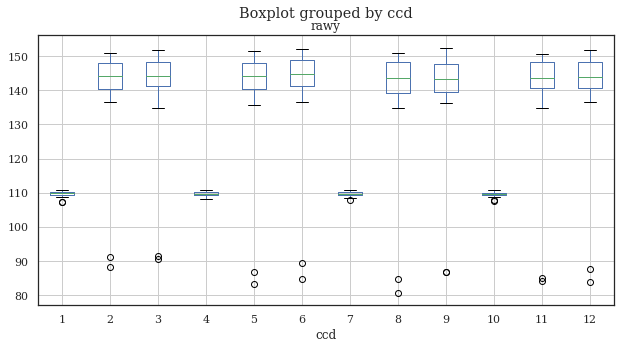

In [5]:
#
# extract the mean RAWY for each CCD
#
boxplot = tab.boxplot(column=['rawy'],by='ccd',figsize=(10,5))
fig = boxplot.get_figure()
fig.savefig(f"{wdir}/boxplot_rawy_all.png",dpi=100)
grouped = tab.groupby('ccd')
rawy = grouped['rawy'].describe()
rawy
#rawy["50%"]
# to get the mean RAWY for a CCD use rawy['mean'].values[CCDNR-1]

## Reading the current CTI CCF

I will use my previous PN Large Window mode CCF file, not yet available in the public area. It is called `/xdata/xcaldata/XMM/IVAN/ccfdev/EPN_CTI_0052.CCF` and incorporates only two energy points at Al K$\alpha$ (1.46 keV) and Cu K$\alpha$ (8.04 keV) for PN LW mode, and has a correction curve per quadrant. The same per-quadrant curve is applicable for all of the three CCDs in this quadrant.


In [6]:
#
# read the current long-term CCF.
#
ccfdir1 = '/xdata/ccf/pub'
ccfdir2 = '/xdata/xcaldata/XMM/IVAN/ccfdev'
#
# energy_index=0 is for Al Ka (1.486 keV)
# energy_index=1 is for Mn Ka (5.8988 keV)
# energy_index=2 is for Cu Ka (8.04 keV)
#
# testing CCF for Oct 2019 update, now obsolete
#tcuka = read_cti_ccf(f"{ccfdir}/EPN_CTI_0051.CCF_test102",mode_id=2,energy_index=1)
#
tcuka1 = read_cti_ccf(f"{ccfdir1}/EPN_CTI_0050.CCF",mode_id=2,energy_index=2)
tt1 = tcuka1[1]['times']
tcuka2 = read_cti_ccf(f"{ccfdir2}/EPN_CTI_0051.CCF_test102",mode_id=2,energy_index=1)
tt2 = tcuka2[1]['times']

cti1 = {}
coef1 = {}
a0_1 = {}
#
cti2 = {}
coef2 = {}
a0_2 = {}
#
for i in range(12):
    ccd = i+1
    mean_rawy = rawy['mean'].values[i]
    # index 1 is the currently available public CCF
    cti1[ccd] = {'x':[],'y':[]}
    cti1[ccd]['x'] = tt1
    coef1[ccd] = tcuka1[ccd]['tcoeff']
    a0_1[ccd] = coef1[ccd][0]
    cti1[ccd]['y'] = np.power((1.0 - coef1[ccd])/(1.0 - a0_1[ccd]),mean_rawy)
    #
    # index 2 is for the tests done in Oct 2020
    cti2[ccd] = {'x':[],'y':[]}
    cti2[ccd]['x'] = tt2
    coef2[ccd] = tcuka2[ccd]['tcoeff']
    a0_2[ccd] = coef2[ccd][0]
    cti2[ccd]['y'] = np.power((1.0 - coef2[ccd])/(1.0 - a0_2[ccd]),mean_rawy)
#

## The long-term CTI effect in terms of $E_{obs}/E_{lab}$

We will freeze the correction curve (per quadrant) for t <= 15 and only change the curve for t > 15 using the currently available observations.


In [7]:
#
# new pandas dataframe sorted on time
#
stab = tab.sort_values(['delta_time'])
#

### Plot the data and the current curves in the CCF

Will also calculate the residuals using linear interpolation.

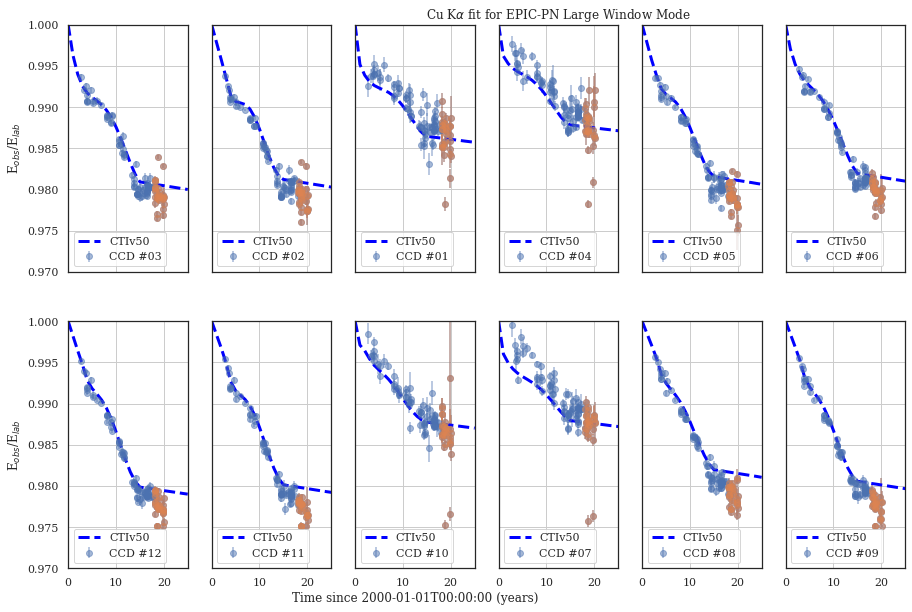

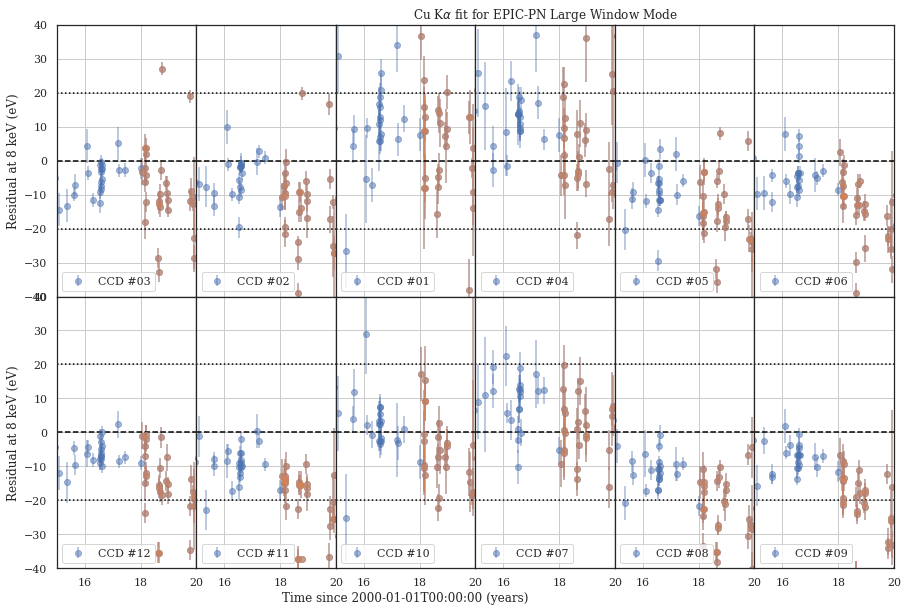

In [8]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
fig2, axs2 = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
# zooming on time, only used in the residual plot
zoom = (15,20)
#
# CCD position in plot
#
mapping = {1: [0,2], 2: [0,1], 3: [0,0], 4: [0,3], 5: [0,4], 6: [0,5],
          7: [1,3], 8: [1,4], 9: [1,5], 10: [1,2], 11: [1,1], 12: [1,0]}
for j in range(12):
    ccd = j+1
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE <= 1.0)]
    #
    xin = xtab.delta_time
    yin = xtab.ratioE
    yin_err = xtab.ratioE_err
    #
    # now calculate the residuals
    #
    fitted = np.interp(xin,cti1[ccd]['x'],cti1[ccd]['y'])
    residual = (yin - fitted)*8000.0 # in eV
    residual_err = yin_err*8000.0
    #
    # identify the new observations
    #
    inew = np.where(xtab.rev > 3306)[0]
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    # now the current CCF correction
    axs[kx,ky].plot(cti1[ccd]['x'],cti1[ccd]['y'],color='blue',ls='dashed',lw=3,label='CTIv50')
    # and the data
    axs[kx,ky].errorbar(xin,yin,yerr=(yin_err,yin_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    axs[kx,ky].errorbar(xin.iloc[inew],yin.iloc[inew],yerr=(yin_err.iloc[inew],yin_err.iloc[inew]),fmt='o',alpha=0.5)
    axs[kx,ky].set_xlim((0,25))
    axs[kx,ky].set_ylim((0.97,1.0))
    axs[kx,ky].grid(True)
    axs[kx,ky].legend(loc=3)
    if (ccd == 4):
        axs[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs[kx,ky].set_ylabel(r"E$_{obs}$/E$_{lab}$")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    #
    # the residual plot
    axs2[kx,ky].errorbar(xin,residual,yerr=(residual_err,residual_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    axs2[kx,ky].errorbar(xin.iloc[inew],residual.iloc[inew],yerr=(residual_err.iloc[inew],residual_err.iloc[inew]),fmt='o',alpha=0.5)
    #axs[kx,ky].errorbar(xin.iloc[inew],yin.iloc[inew],yerr=(yin_err.iloc[inew],yin_err.iloc[inew]),fmt='o')
    axs2[kx,ky].axhline(0.0,color='black',ls='dashed')
    axs2[kx,ky].axhline(-20.0,color='black',ls='dotted')
    axs2[kx,ky].axhline(20.0,color='black',ls='dotted')
    axs2[kx,ky].set_xlim(zoom)
    axs2[kx,ky].set_ylim((-40,40.0))
    axs2[kx,ky].grid(True)
    axs2[kx,ky].legend(loc=3)
    if (ccd == 4):
        axs2[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs2[kx,ky].set_ylabel(r"Residual at 8 keV (eV)")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs2[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_v50_noctiy.png",dpi=100)
plt.show();
plt.close();

## Change the CTI curve for t > 15

I will only change the slope from 0.999 to 0.995 for t > 15

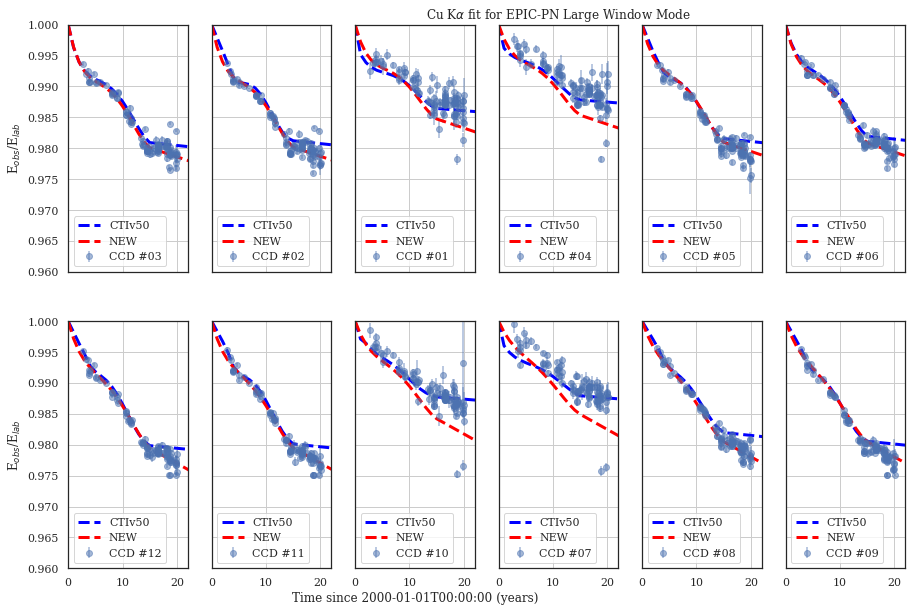

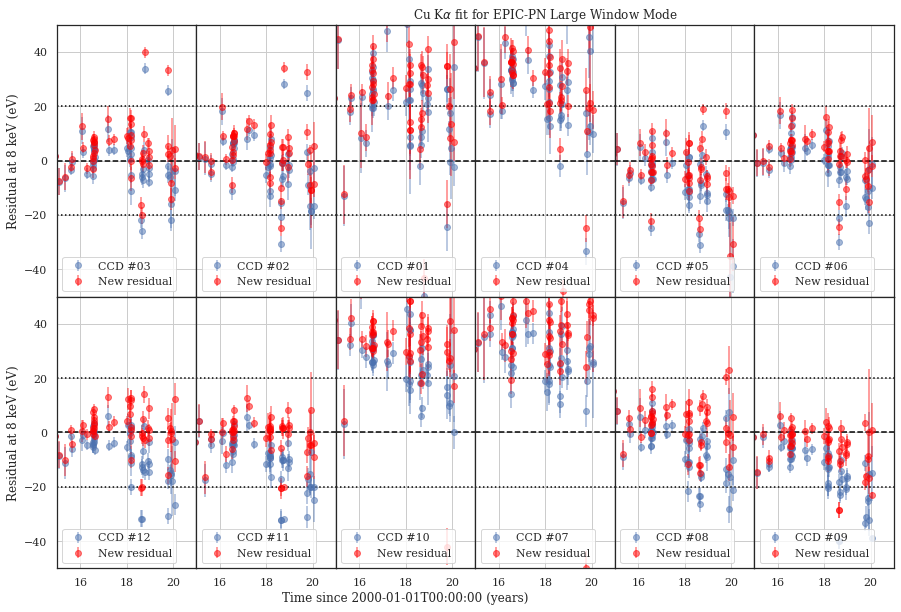

In [9]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
fig2, axs2 = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
# zooming on time, only used in the residual plot
zoom = (15,21)
#
# CCD position in plot
#
mapping = {1: [0,2], 2: [0,1], 3: [0,0], 4: [0,3], 5: [0,4], 6: [0,5],
          7: [1,3], 8: [1,4], 9: [1,5], 10: [1,2], 11: [1,1], 12: [1,0]}
# per quadrant mapping
quadrant = {1: "q0", 2: "q0", 3: "q0", 4: "q1", 5: "q1", 6: "q1",
          7: "q2", 8: "q2", 9: "q2", 10: "q3", 11: "q3", 12: "q3"}
#
for j in range(12):
    ccd = j+1
    quad = quadrant[ccd]
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE <= 1.0)]
    #
    xin = xtab.delta_time
    yin = xtab.ratioE
    yin_err = xtab.ratioE_err
    #
    # now calculate the residuals
    #
    xrate = 0.997
    if (quad in ['q2','q3']):
        xrate = 0.995
    istart = 15
    newy = cti2[ccd]['y'].copy()
    m = (newy[istart]*xrate - newy[istart])/(cti2[ccd]['x'][-1] - cti2[ccd]['x'][istart])
    newy[istart:] = m*(cti2[ccd]['x'][istart:] - cti2[ccd]['x'][istart]) + newy[istart]
    #
    fitted = np.interp(xin,cti2[ccd]['x'],cti2[ccd]['y'])
    residual = (yin - fitted)*8000.0 # in eV
    residual_err = yin_err*8000.0
    # new curve
    fitted2 = np.interp(xin,cti2[ccd]['x'],newy)
    residual2 = (yin - fitted2)*8000.0 # in eV
    #
    # identify the new observations
    #
    #inew = np.where(xtab.rev > 3306)[0]
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    # now the current CCF correction
    axs[kx,ky].plot(cti1[ccd]['x'],cti1[ccd]['y'],color='blue',ls='dashed',lw=3,label='CTIv50')
    axs[kx,ky].plot(cti2[ccd]['x'],newy,color='red',ls='dashed',lw=3,label='NEW')
    # and the data
    axs[kx,ky].errorbar(xin,yin,yerr=(yin_err,yin_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    #axs[kx,ky].errorbar(xin.iloc[inew],yin.iloc[inew],yerr=(yin_err.iloc[inew],yin_err.iloc[inew]),fmt='o',alpha=0.5)
    axs[kx,ky].set_xlim((0,22))
    axs[kx,ky].set_ylim((0.96,1.0))
    axs[kx,ky].grid(True)
    axs[kx,ky].legend(loc=3)
    if (ccd == 4):
        axs[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs[kx,ky].set_ylabel(r"E$_{obs}$/E$_{lab}$")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    #
    # the residual plot
    axs2[kx,ky].errorbar(xin,residual,yerr=(residual_err,residual_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    axs2[kx,ky].errorbar(xin,residual2,yerr=(residual_err,residual_err),fmt='o',c='red',label=f'New residual',alpha=0.5)
    #axs2[kx,ky].errorbar(xin.iloc[inew],residual.iloc[inew],yerr=(residual_err.iloc[inew],residual_err.iloc[inew]),fmt='o',alpha=0.5)
    #axs[kx,ky].errorbar(xin.iloc[inew],yin.iloc[inew],yerr=(yin_err.iloc[inew],yin_err.iloc[inew]),fmt='o')
    axs2[kx,ky].axhline(0.0,color='black',ls='dashed')
    axs2[kx,ky].axhline(-20.0,color='black',ls='dotted')
    axs2[kx,ky].axhline(20.0,color='black',ls='dotted')
    axs2[kx,ky].set_xlim(zoom)
    axs2[kx,ky].set_ylim((-50,50.0))
    axs2[kx,ky].grid(True)
    axs2[kx,ky].legend(loc=3)
    if (ccd == 4):
        axs2[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs2[kx,ky].set_ylabel(r"Residual at 8 keV (eV)")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs2[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_noctiy.png",dpi=100)
plt.show();
plt.close();

## Test 2: Combined curves for the non-central CCDs, per quadrant

The idea is to combine all non-central CCDs and derive a curve based on quadrant: 
* `Q_0`:  CCD 2 & 3 and use it for CCD 1
* `Q_1`: CCD 5 & 6 and use it for CCD 4
* `Q_2`: CCD 8 & 9 and use it for CCD 7
* `Q_3`: CCD 11 & 12 and use it for CCD 10

The long-term CTI correction for each of the central 4 CCDs will be the combined one, per quadrant. I.e. the curve for the boresight `CCDNR=4` will be the curve for quadrant `Q_1` etc.


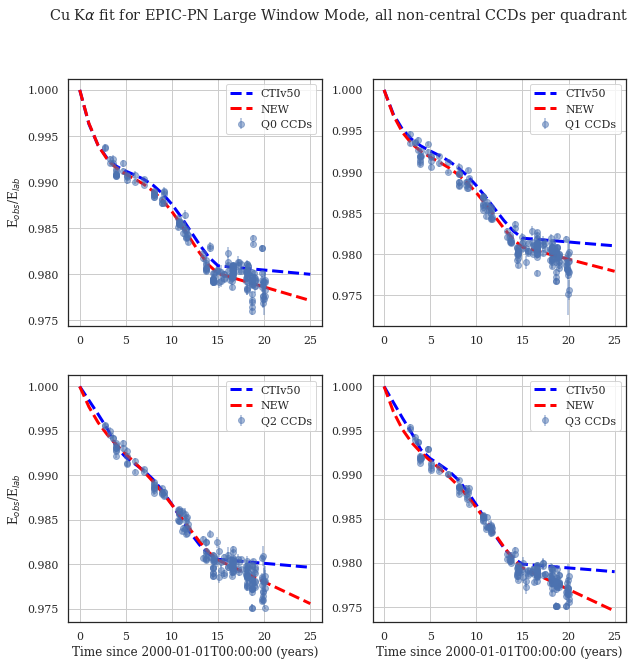

In [10]:
#
# plot data and current CCF curves, no fit is performed
#
fig3 = plt.figure(figsize=(10,10))

qtab = {}
qtab['q0'] = stab[(stab.ccd == 2) | (stab.ccd == 3)]
qtab['q1'] = stab[(stab.ccd == 5) | (stab.ccd == 6)]
qtab['q2'] = stab[(stab.ccd == 8) | (stab.ccd == 9)]
qtab['q3'] = stab[(stab.ccd == 11) | (stab.ccd == 12)]
#
ccds = {'q0': [1,2,3], 'q1': [4,5,6], 'q2': [7,8,9], 'q3': [10,11,12]}
#
# save the results per quadrant
results = {}
#
for i,iq in enumerate(['q0','q1','q2','q3']):
    # pick up non-central CCD for the CCF curve
    ccd = ccds[iq][-1]
    #
    xin = qtab[iq].delta_time
    yin = qtab[iq].ratioE
    yin_err = qtab[iq].ratioE_err
    # the new suggested curve for t > 15
    xrate = 0.997
    if (iq in ['q2','q3']):
        xrate = 0.995      
    istart = 15
    newy = cti2[ccd]['y'].copy()
    m = (newy[istart]*xrate - newy[istart])/(cti2[ccd]['x'][-1] - cti2[ccd]['x'][istart])
    newy[istart:] = m*(cti2[ccd]['x'][istart:] - cti2[ccd]['x'][istart]) + newy[istart]
    #
    results[iq] = newy
    #
    ax3 = fig3.add_subplot(2, 2, i+1)
    ax3.errorbar(xin,yin,yerr=yin_err,fmt='o',label=f'{iq.upper()} CCDs',alpha=0.5)
    ax3.plot(cti1[ccd]['x'],cti1[ccd]['y'],color='blue',ls='dashed',lw=3,label='CTIv50')
    ax3.plot(cti2[ccd]['x'],results[iq],color='red',ls='dashed',lw=3,label='NEW')
    ax3.grid()
    if (i in [0,2]): 
        ax3.set_ylabel(r"E$_{obs}$/E$_{lab}$")
    if (i in [2,3]): 
        ax3.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    ax3.legend();
    #if (i == 0):
    #    ax3.set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs per quadrant")
plt.suptitle(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs per quadrant")
#plt.savefig(f"{wdir}/plots/cuka_curves_cti54_per_quad.png",dpi=100)
plt.show();
plt.close();

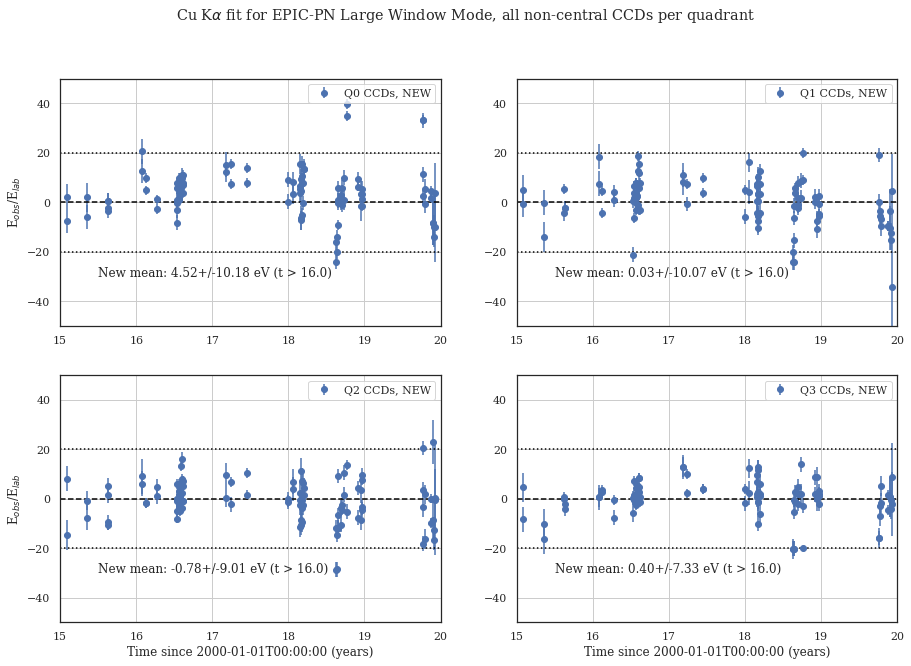

In [11]:
#
# plot the residuals with the current and the new curve
#
fig3 = plt.figure(figsize=(15,10))

qtab = {}
qtab['q0'] = stab[(stab.ccd == 2) | (stab.ccd == 3)]
qtab['q1'] = stab[(stab.ccd == 5) | (stab.ccd == 6)]
qtab['q2'] = stab[(stab.ccd == 8) | (stab.ccd == 9)]
qtab['q3'] = stab[(stab.ccd == 11) | (stab.ccd == 12)]
#
ccds = {'q0': [1,2,3], 'q1': [4,5,6], 'q2': [7,8,9], 'q3': [10,11,12]}
#
zoom = (15,20)
for i,iq in enumerate(['q0','q1','q2','q3']):
    # pick up non-central CCD for the CCF curve
    ccd = ccds[iq][-1]
    #
    xin = qtab[iq].delta_time
    yin = qtab[iq].ratioE
    yin_err = qtab[iq].ratioE_err
    # the new suggested curve for t > 15
    # will use the curves results[quadrant] from the previous cell
    #
#     xrate = 0.997
#     if (iq in ['q2','q3']):
#         xrate = 0.995      
#     istart = 15
#     newy = cti[ccd]['y'].copy()
#     m = (newy[istart]*xrate - newy[istart])/(cti[ccd]['x'][-1] - cti[ccd]['x'][istart])
#     newy[istart:] = m*(cti[ccd]['x'][istart:] - cti[ccd]['x'][istart]) + newy[istart]
#     #
#     results[iq] = newy
    #
    fitted = np.interp(xin,cti1[ccd]['x'],cti1[ccd]['y'])
    residual = (yin - fitted)*8000.0 # in eV
    residual_err = yin_err*8000.0
    # new curve
    fitted2 = np.interp(xin,cti2[ccd]['x'],results[iq])
    residual2 = (yin - fitted2)*8000.0 # in eV
    #
    # calculate statistics for the new data
    #
    #ix = np.where(xin >= float(istart))[0]
    xstart = 16.0
    ix = np.where(xin >= xstart)[0]
    mean_current = np.mean(residual.iloc[ix])
    std_current = np.std(residual.iloc[ix])
    mean_new = np.mean(residual2.iloc[ix])
    std_new = np.std(residual2.iloc[ix])
    #
    ax3 = fig3.add_subplot(2, 2, i+1)
    #ax3.errorbar(xin,residual,yerr=residual_err,fmt='o',label=f'{iq.upper()} CCDs, CTIv52',alpha=0.5)
    ax3.errorbar(xin,residual2,yerr=residual_err,fmt='o',label=f'{iq.upper()} CCDs, NEW')
    ax3.grid()
    ax3.axhline(0.0,color='black',ls='dashed')
    ax3.axhline(-20.0,color='black',ls='dotted')
    ax3.axhline(20.0,color='black',ls='dotted')
    ax3.set_xlim(zoom)
    ax3.set_ylim((-50,50.0))
    if (i in [0,2]): 
        ax3.set_ylabel(r"E$_{obs}$/E$_{lab}$")
    if (i in [2,3]): 
        ax3.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    #ax3.text(0.1,0.1,f"Current mean: {mean_current:0.2f}+/-{std_current:.2f} eV (t > {xstart})",transform=ax3.transAxes)
    ax3.text(0.1,0.2,f"New mean: {mean_new:0.2f}+/-{std_new:.2f} eV (t > {xstart})",transform=ax3.transAxes)
    ax3.legend();
#        
plt.suptitle(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs per quadrant")
#plt.savefig(f"{wdir}/plots/cuka_cti54_results_Feb2020.png",dpi=100)
plt.show();
plt.close();

## Prepare for the CCF

This step require the average RAWY per CCD and then convert the ratio `Q=Eobs/Elab` to the $g(t)$  function:

$Q = E_{obs}/E_{lab} = \left[\frac{1 - g(t)}{1-a_0}\right]^{RAWY}$,

where $a_0 = g(t_0)$, the measured CTI at launch. We know $a_0$ at 5.8988 keV but not at 8.04 keV. so we use the value for 5.8988 keV, $a_0 = 0.00043236$.

Rewriting the equation we obtain:

$g(t) = 1 - (1-a_0)\times Q^{1/RAWY}$.  

The tabulated function $g(t)$ is stored in the EPN_CTI calibartion file.

Will also investigate an alternative way, when $a_0$ is unknown. Then we can set it to zero:

$Q = \left(1 - g(t)\right)^{RAWY}$,

and consequently 

$g(t) = 1 - Q^{1/RAWY}$.

As shown in the boxplot above, for all non-central CCDs the average `RAWY` is 143 +/- 1 and we assume this value for the calculation of $g(t)$.

We construct `EPN_CTI_0054.CCF` with the per-quadrant curves.

In [14]:
#
# results dictionary per CCD is the fitted Eobs/Elab (the red line).
#
# TCOEFF ( = gt1) will be calculated for a fixed RAWY and a0 for each CCDs
gt1 = {}
mean_rawy = 143.0
a0 = 0.0004
for i in range(12):
    ccd = i + 1
    iq = quadrant[ccd] # quadrants mapping
    gt1[ccd] = 1.0 - (1.0 - a0)*np.power(results[iq],1.0/mean_rawy)
    gt1[ccd][0] = a0
#

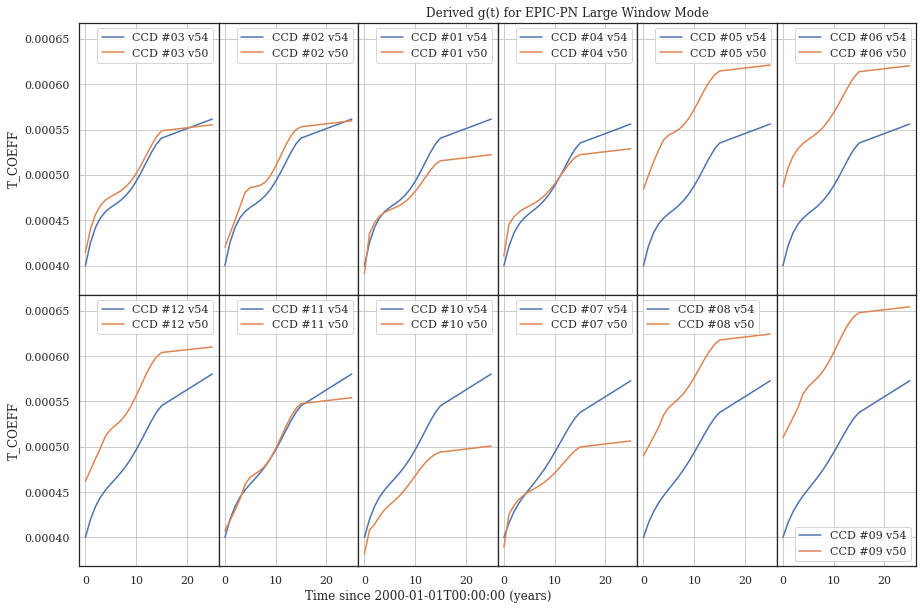

In [15]:
#
# now plot and compare g(t) for consistency
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    axs[kx,ky].plot(tt2,gt1[ccd],label=f'CCD #{ccd:02} v54')
    axs[kx,ky].plot(tt1,coef1[ccd],label=f'CCD #{ccd:02} v50')
    axs[kx,ky].legend()
    axs[kx,ky].grid(True)
    if (ccd == 4):
        axs[kx,ky].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs[kx,ky].set_ylabel("T_COEFF")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show()
plt.close();

## Generate new CTI CCF files

Will reuse the current one and just update `TCOEFF` with the new results.

**Important note**: in `EPN_CTI_0052.CCF_testa0` only Al K$\alpha$ line at 1.486 keV and Cu K$\alpha$ line at 8.04 keV are available for Pn Large Window Mode. I only replace the curves in this file, without adding or removing anything. Just a change of the slope for t > 15.

The output file is called `EPN_CTI_0054.CCF_testa0`.

In [16]:
import time
today = time.strftime("%c")
#
ccfdir = '/xdata/xcaldata/XMM/IVAN/ccfdev'
#ccfdir = '/ccf/valid'
ccf52_file = f"{ccfdir}/EPN_CTI_0051.CCF_test102"
hdu52 = fits.open(f"{ccf52_file}")
ltc52 = hdu52['LONG_TERM_CTI']
n52 = len(ltc52.data)
#

In [17]:
for i in np.arange(n52):
    # we only change MODE_ID = 2, i.e. Large Window Mode
    if (ltc52.data['MODE_ID'][i] != 2):
        continue
    # and we only change the TCOEFF for energy 8.04 keV
    if (ltc52.data['ENERGY'][i] < 8.0):
        continue
    # now loop over the CCDNR
    for j in np.arange(1,13):
        if (ltc52.data['CCD_ID'][i] == j):
            ltc52.data['T_COEFF'][i] = gt1[j]
            break
        #
    #
#
if ('HISTORY' in hdu52['LONG_TERM_CTI'].header.keys()):
    hdu52['LONG_TERM_CTI'].header.remove('HISTORY',remove_all=True)
hdu52['LONG_TERM_CTI'].header.add_history(f'Created by Ivan V, {today}')
# new file name
hdu52[0].header['FILENAME'] = "EPN_CTI_0054.CCF"
hdu52[0].header['ISSUE'] = 54
hdu52.writeto(f"{wdir}/../ccfdev/EPN_CTI_0054.CCF_testa0",overwrite=True)
hdu52.close()

## Compare the new CCF with the current one

Just in case, we check if they are different.

One way to check is with plotting, another way is to dump the content to an ascii files and do `diff` from the OS.


In [18]:
def dump_cti(ccf_file,fileout=None):
    #
    # will dump the LONG_TERM_CTI extension in an ascii file with format following the standard one
    #
    hdu = fits.open(ccf_file)
    extname = 'LONG_TERM_CTI'
    ltc = hdu[extname]
    nt = len(ltc.data)
    if (fileout != None):
        fout = open(fileout,'w')
    #
    for j in np.arange(nt):
        if (fileout != None):
            print ("{:3} : {:3} :   {:6.4f} : ".format(ltc.data['MODE_ID'][j],ltc.data['CCD_ID'][j],\
               ltc.data['ENERGY'][j]),end="",file=fout)
        print ("{:3} : {:3} :   {:6.4f} : ".format(ltc.data['MODE_ID'][j],ltc.data['CCD_ID'][j],\
               ltc.data['ENERGY'][j]),end="",file=fout)
        tcoeff = ltc.data['T_COEFF']
        nrow,ncol = tcoeff.shape
        for l in np.arange(ncol):
            print ("  {:3.6e}".format(tcoeff[j,l]),end="",file=fout)
        print (" :   1",file=fout)
        #
    #    
    if (fileout != None):
        fout.close()
    return fileout

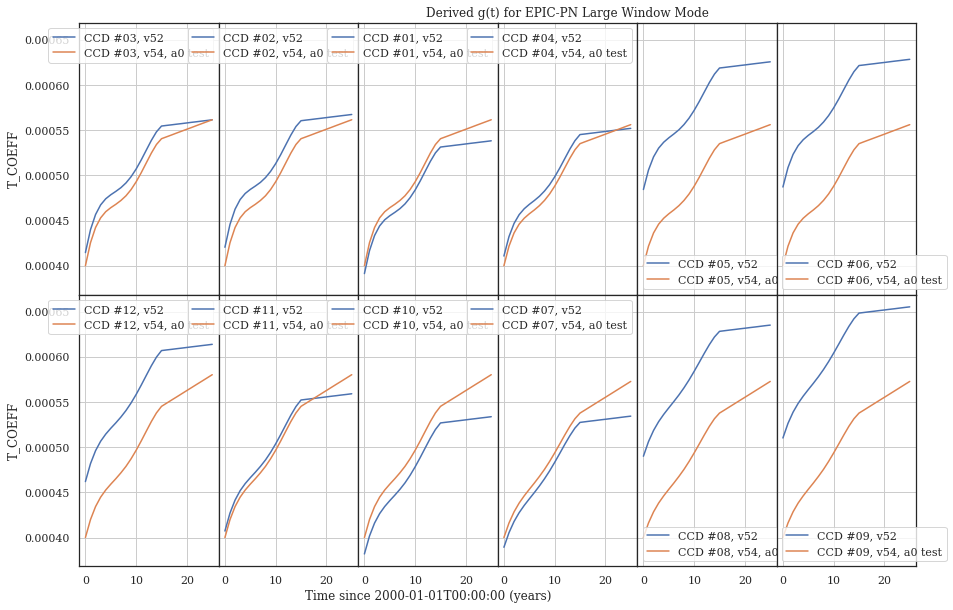

In [20]:
#ccfdir = '/ccf/valid'
ccfdir = '/xdata/xcaldata/XMM/IVAN/ccfdev'
ccf52_file = f"{ccfdir}/EPN_CTI_0051.CCF_test102"
t52 = read_cti_ccf(ccf52_file,mode_id=2,energy_index=1)
x52 = t52[1]['times']
#
ccf54_file = f"{ccfdir}/EPN_CTI_0054.CCF_testa0"
t54 = read_cti_ccf(ccf54_file,mode_id=2,energy_index=1)
x54 = t54[1]['times']
#
# dump to ascii
#
fx52 = dump_cti(ccf52_file,fileout=f"{ccfdir}/long_term_cti_0052.dat_11Feb2020")
fx54a = dump_cti(ccf54_file,fileout=f"{ccfdir}/long_term_cti_0054.dat_14Feb2020")
#
# now plot and compare
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    y52 = t52[ccd]['tcoeff']
    y54 = t54[ccd]['tcoeff']
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    axs[kx,ky].plot(x52,y52,label=f'CCD #{ccd:02}, v52')
    axs[kx,ky].plot(tt2,y54,label=f'CCD #{ccd:02}, v54, a0 test')
    axs[kx,ky].legend()
    axs[kx,ky].grid(True)
    if (ccd == 4):
        axs[kx,ky].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs[kx,ky].set_ylabel("T_COEFF")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show()
plt.close();

## Check the Cu K$\alpha$ line results after applying the correction

Current run is with `EPN_CTI_0054.CCF`

The fit results are stored in file: `~/IVAN/Cu-line/fit_results_cuka_cti54_Feb2020.csv`.

In [26]:
wdir = f"{home}/IVAN/Cu-line"
t1 = Table.read(f'{wdir}/fit_results_cuka_cti54_Feb2020.csv',comment="\s*#")
t1["ratioE"] = Column(t1["lineE"]/8.04)
t1["ratioE_err"] = Column(t1["lineE_err"]/8.04)
t1["diffE"] = Column(t1["lineE"] - 8.04)
t1["diffE_err"] = Column(t1["lineE_err"])
tab1 = t1.to_pandas()

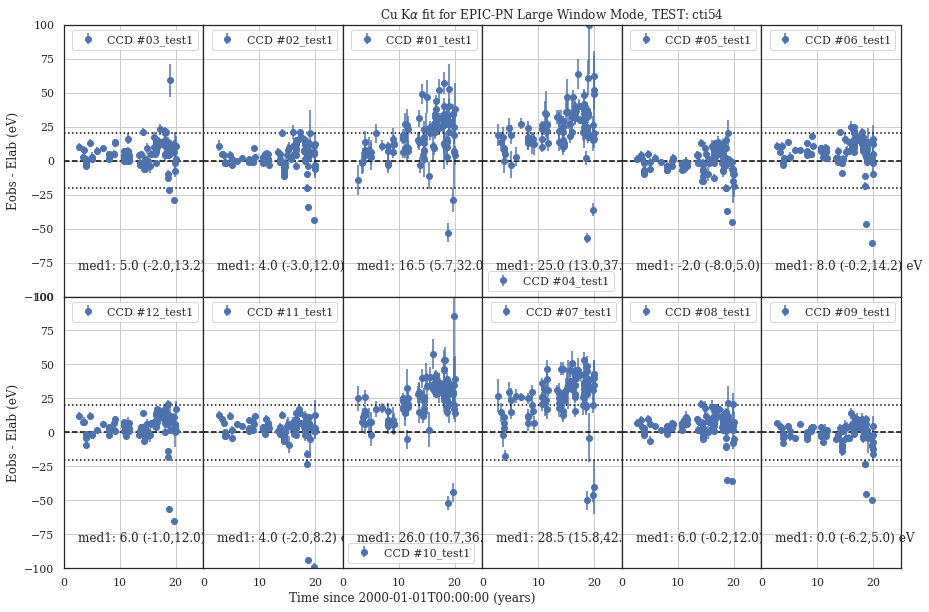

In [27]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
stab1 = tab1.sort_values(['delta_time'])
#
vers = 'cti54'
for j in range(12):
    ccd = j+1
    xtab1 = stab1[stab1.ccd == ccd]
    #
    xin1 = xtab1.delta_time
    yin1 = xtab1.diffE*1000.0 # in eV
    yin1_err = xtab1.diffE_err*1000.0 # in eV
    med1, low1, up1 = np.quantile(yin1,[0.5,0.16,0.84])
    #
    kj = mapping[ccd][0]
    k = mapping[ccd][1]
    axs[kj,k].errorbar(xin1,yin1,yerr=(yin1_err,yin1_err),fmt='o',label=f'CCD #{ccd:02}_test1')
    axs[kj,k].axhline(0.0,color='black',ls='dashed')
    axs[kj,k].axhline(-20.0,color='black',ls='dotted')
    axs[kj,k].axhline(20.0,color='black',ls='dotted')
    #
    axs[kj,k].text(0.1,0.1,f'med1: {med1:.1f} ({low1:.1f},{up1:.1f}) eV',transform=axs[kj,k].transAxes)
    #
    axs[kj,k].set_xlim((0,25))
    axs[kj,k].set_ylim((-100.0,100.0))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, TEST: {vers}")
    if (ccd == 3 or ccd == 12):
        axs[kj,k].set_ylabel("Eobs - Elab (eV)")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/plots/cuka_results54_perCCD.png",dpi=100)
plt.show();
plt.close();

## Check per quadrant

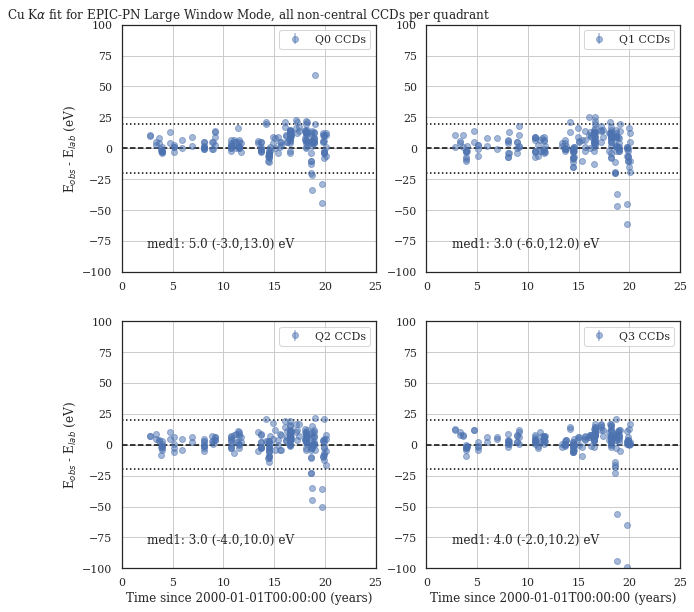

In [113]:
#
fig3 = plt.figure(figsize=(10,10))

stab = tab1.sort_values(['delta_time'])

qtab = {}
qtab['q0'] = stab[(stab.ccd == 2) | (stab.ccd == 3)]
qtab['q1'] = stab[(stab.ccd == 5) | (stab.ccd == 6)]
qtab['q2'] = stab[(stab.ccd == 8) | (stab.ccd == 9)]
qtab['q3'] = stab[(stab.ccd == 11) | (stab.ccd == 12)]
#
ccds = {'q0': [1,2,3], 'q1': [4,5,6], 'q2': [7,8,9], 'q3': [10,11,12]}
#
#
for i,iq in enumerate(['q0','q1','q2','q3']):
    # pick up non-central CCD for the CCF curve
    ccd = ccds[iq][-1]
    #
    xin = qtab[iq].delta_time
    yin = (qtab[iq].ratioE - 1.0)*8040.0
    yin_err = qtab[iq].ratioE_err
    #
    med1, low1, up1 = np.quantile(yin,[0.5,0.16,0.84])
    ax3 = fig3.add_subplot(2, 2, i+1)
    ax3.errorbar(xin,yin,yerr=yin_err,fmt='o',label=f'{iq.upper()} CCDs',alpha=0.5)
    ax3.grid()
    if (i in [0,2]): 
        ax3.set_ylabel(r"E$_{obs}$ - E$_{lab}$ (eV)")
    if (i in [2,3]): 
        ax3.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    ax3.legend();
    if (i == 0):
        ax3.set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs per quadrant")
    ax3.axhline(0.0,color='black',ls='dashed')
    ax3.axhline(-20.0,color='black',ls='dotted')
    ax3.axhline(20.0,color='black',ls='dotted')
    #
    ax3.text(0.1,0.1,f'med1: {med1:.1f} ({low1:.1f},{up1:.1f}) eV',transform=ax3.transAxes)
    #
    ax3.set_xlim((0,25))
    ax3.set_ylim((-100.0,100.0))
plt.savefig(f"{wdir}/plots/cuka_results_cti54.png",dpi=100)
plt.show();
plt.close();

'/home/ivaltchanov/IVAN/Cu-line'

## Check the Fe K$\alpha$ results with the new CCF


In [28]:
#
# define the targets and their redshift
#
targets = ["ngc3227","mkn1040","mkn915","ngc6814",'mkn883','tycho', 'ngc5899','ngc526a','kepler']
#
colors = {"ngc3227":'red',"mkn1040":'green',"mkn915":'blue',"ngc6814":'magenta','mkn883':'cyan','tycho': 'brown',
         'ngc5899': 'lime', 'ngc526a': 'orange', "kepler": "gray", "snr1987a": "pink"}
#
# redshifts
#
redshift = {'ngc4151': 0.003262, 'ngc3227': 0.00386, 'mrk1048': 0.0427, 'ngc3783': 0.009755,\
            'ngc4593': 0.008344, 'ngc5506': 0.00589, 'mcg-5-23-16': 0.008226, 'ngc3516': 0.008816,\
            'ngc5548': 0.01627, 'ngc2992':  0.007296, 'ngc1566': 0.005036, 'iras09149': 0.057150,\
            "iras05078": 0.017879, 'ngc7213': 0.005869,"mkn915": 0.024043,"mkn1040":0.016338,\
            "ngc6814": 0.005227, 'mkn883': 0.03787, 'tycho': 0.0, 'ngc5899': 0.00880, 'ngc526a': 0.01897,
           "kepler": 0.0, "snr1987a": 0.0}
feK = 6.399 # the weighted mean of Fe Kalpha_2 at 6.3908 (intensity 50) and Fe Kalpha_1 at 6.40308 (intensity 100)

Adding ngc3227
Adding mkn1040
Adding mkn915
Adding ngc6814
Adding mkn883
Adding tycho
Adding ngc5899
Adding ngc526a
Adding kepler


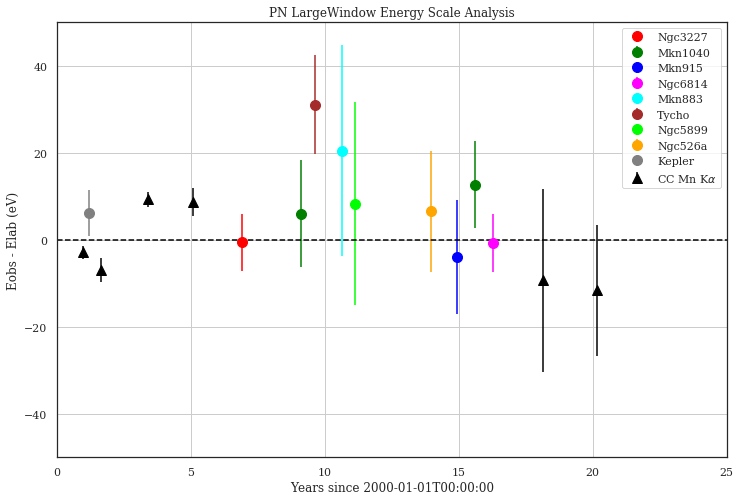

In [35]:
#
# calculate the differences and plot
# save some info in a tex table
#
xratio64 = []
xratio64err = []
xrtime = []

msize=10
xcols = {}
fig, ax = plt.subplots(figsize=(12,8))

vers = "cti54"
#vers = "cti51_test1"
#vers = "cti51x_08"
#vers = "cti48"
#vers = "nocti"
k = 0
symb = 'o'

srcdir = f"{home}/IVAN/PN_LW/sources"

for target in targets:
    print (f"Adding {target}")
    #
    lineX =  feK/(1.0 + redshift[target]) # redshifted line position
    if (target == 'snr1987a'):
        lineX = 6.7463 # taken from the Full Frame mode
    # test 1
    #out_tab = f'{srcdir}/{target}_xspec_output_cti51_test1.csv'
    out_tab = f'{srcdir}/{target}_xspec_output_cti54.csv'
    if (not os.path.isfile(out_tab)):
        print (f"No {vers} results found for target {target}: {out_tab}")
        continue
    t1 = Table.read(out_tab,data_start=0,names=("obsid","expo","rev","delta_time","submode",\
                                  "xfilt","inst","ontime",\
                                  "lineE","lineE_err","lineE_err2","cstat","chi2r","dof"))
    nt1 = len(t1)
    #
    rev = t1['rev'].data
    rtime = t1['delta_time'].data
    xrtime = np.concatenate((xrtime,rtime))
    inst = t1['inst'].data
    line = t1['lineE'].data
    #lineErr = t['lineE_err'].data
    lineErr = t1['lineE_err2'].data # use the fit error (single parameter)
    rchi2 = t1["chi2r"].data
    diff = (line - lineX)*1000.0
    errs = [lineErr*1000,lineErr*1000.0]
    ratio = line/lineX
    ratio_err = [lineErr/lineX,lineErr/lineX]
    #
    ax.errorbar(rtime,diff,yerr=(errs),fmt=symb,color=colors[target],\
              markersize=msize,label=target.capitalize())
#
# customized legend

#    
vers = "cti54"
ccdir = "/xdata/xcaldata/XMM/IVAN/PN_LW/CalClosed"
cc_files = glob.glob(f"{ccdir}/*_xspec_results_{vers}.csv")
mnka_lab = 5.8988
cclab = r"CC Mn K$\alpha$"
for jj in cc_files:
    tcc = Table.read(jj)
    rtime_cc = tcc['delta_time'].data
    rev_cc = tcc['rev'].data
    mnka = tcc['line2'].data
    mnka_err = 1000*tcc['line2err'].data
    cc_diff = 1000*(mnka - mnka_lab)
    ix = np.where(tcc['ccd'] == 14)[0]
    ax.errorbar(rtime_cc[ix]+0.3,cc_diff[ix],yerr=(mnka_err[ix]),fmt="^",\
               markersize=msize,color='black',label=cclab)
    cclab = ""
#
#ax.plot(19,68,'ko',markersize=10)
#ax.text(19.5,68,'test1: single CTI curve')
#ax.plot(19,62,'ko',markersize=10,fillstyle='none')
#ax.text(19.5,62,'per quadrant')
#
ax.axhline(0.0,color='black',linestyle='dashed')
ax.set_ylabel(r"Eobs - Elab (eV)")
ax.set_xlabel(r"Years since 2000-01-01T00:00:00")
ax.grid(True)
ax.set_xlim([0.0,25.0])
ax.set_ylim([-50.0,50.0])
#ax.set_title(f"PN SmallWindow Energy Scale Analysis\n Test #{ver}")
ax.set_title("PN LargeWindow Energy Scale Analysis")
plt.legend(numpoints=1)
plt.savefig(f'{wdir}/../PN_LW/pnlw_agn_cc_cti54_results.png',dpi=100)
plt.show();
plt.close()
#

In [132]:
wdir

'/home/ivaltchanov/IVAN/Cu-line'